# Reinforcement Learning with Function Approximation

In [28]:
!pip install torch==1.2.0 torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull origin master > /dev/null 2>&1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [29]:
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
from pathlib import Path
import numpy as np
import base64 
import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
import pandas as pd 
import itertools
import seaborn as sns 
# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |


**Tutorials on PyTorch:** https://pytorch.org/tutorials/


## OpenAI gym
We will consider environments provided by OpenAI gym
This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

In [0]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True)

In [32]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

## REINFORCE

**Implementation of the REINFORCE algorithm**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure. You will need to code the method `optimize_model`.

In [0]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

Create the model based on the properties of the MDP you want to solve

In [34]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
)


 base agent (as an abstract class) that will be extended in the next cell with an implementation of `optimize_model`.

In [0]:
class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = Model(self.env.observation_space.shape[0], self.env.action_space.n)
        self.model=self.model.float()
        self.gamma = config['gamma']
        
        # the optimizer used by PyTorch (Stochastic Gradient, Adagrad, Adam, etc.)
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)
    
    # Method to implement
    def _compute_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """
        
        raise NotImplementedError
    
    # Method to implement
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        
        raise NotImplementedError
    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{n_update}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self, render=False):
        """Evaluate the agent on a single trajectory            
        """
        with torch.no_grad():
            
            observation = torch.from_numpy(self.monitor_env.reset()).float()
            reward_episode = 0
            done = False
                
            while not done:
                action = self.model.select_action(observation)
                observation, reward, done, info = self.monitor_env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                reward_episode += reward
            
            self.monitor_env.close()
            if render:
                show_video("./gym-results")
                print(f'Reward: {reward_episode}')
            print(f'Reward: {reward_episode}')

Finally agent implementation

In [0]:
class REINFORCE(BaseAgent):
    
    def _compute_returns(self, rewards):

      cum_discounted_rewards = []
      for t in range(len(rewards)):
          R_t = 0 
          pw = 0
          for r in rewards[t:]:
              R_t+= + self.gamma**pw * r
              pw = pw + 1
          """Notice here that We don't do any normalization for the rewards we could do this 
        as this is common practice even though we're treating one single type of data"""
          cum_discounted_rewards.append(R_t)
      return cum_discounted_rewards    
        
    def optimize_model(self, n_trajectories):
        loss=[]
        reward_trajectories= []
        for trajectory in range(n_trajectories):
          done=False 
          state = torch.from_numpy(self.env.reset()).float()
          log_prob = []
          rewards = []
          while not(done):
            action=self.model.select_action(state)
            action_proba=self.model.forward(state)[action]
            new_state, reward, done, _ = self.env.step(int(action))
            log_prob.append(torch.log(action_proba))
            rewards.append(reward)
            state = torch.from_numpy(new_state).float()
          rewards=self._compute_returns(rewards)
          policy_gradient = []
          for log_proba, R_t in zip(log_prob, rewards):
            policy_gradient.append(-log_proba * R_t)       
          policy_gradient = torch.stack(policy_gradient).sum()
          loss.append(policy_gradient)
          reward_trajectories.append(rewards[0])
          
        loss=torch.stack(loss)*torch.tensor([1/n_trajectories],dtype=torch.float)
        loss=loss.sum()
    
        # Discard previous gradients
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return np.array(reward_trajectories)
    

In [37]:
env_id = 'CartPole-v1'
learning_rate = 0.01
gamma = 1 
seed = 1235

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
pprint(config)


Current config is:
{'env_id': 'CartPole-v1', 'gamma': 1, 'learning_rate': 0.01, 'seed': 1235}


Episode 1/50: rewards 16.9 +/- 6.2
Episode 2/50: rewards 22.48 +/- 9.21
Episode 3/50: rewards 22.7 +/- 11.96
Episode 4/50: rewards 23.44 +/- 11.93
Episode 5/50: rewards 23.22 +/- 10.76
Episode 6/50: rewards 23.94 +/- 11.23
Episode 7/50: rewards 24.26 +/- 12.03
Episode 8/50: rewards 25.64 +/- 14.97
Episode 9/50: rewards 25.28 +/- 16.45
Episode 10/50: rewards 28.86 +/- 17.01
Episode 11/50: rewards 24.1 +/- 13.8
Episode 12/50: rewards 32.84 +/- 19.68
Episode 13/50: rewards 32.58 +/- 15.62
Episode 14/50: rewards 27.54 +/- 15.25
Episode 15/50: rewards 34.42 +/- 16.96
Episode 16/50: rewards 39.12 +/- 21.17
Episode 17/50: rewards 34.34 +/- 18.91
Episode 18/50: rewards 36.7 +/- 19.33
Episode 19/50: rewards 34.42 +/- 24.69
Episode 20/50: rewards 36.5 +/- 20.19
Episode 21/50: rewards 43.3 +/- 21.38
Episode 22/50: rewards 45.04 +/- 19.35
Episode 23/50: rewards 42.98 +/- 22.19
Episode 24/50: rewards 48.56 +/- 28.32
Episode 25/50: rewards 48.58 +/- 25.65
Episode 26/50: rewards 55.1 +/- 31.98
Episod

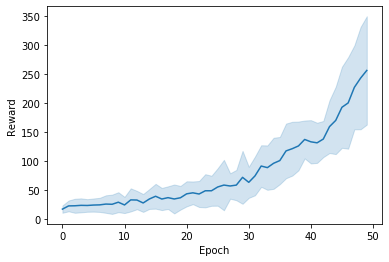

In [38]:
agent = REINFORCE(config)
agent.train(n_trajectories=50, n_update=50)

Evaluate the agent over multiple episodes

In [0]:
#agent.evaluate()

## Policy Evaluation as Supervised Learning

** Implementation of batched gradient algorithm**

Definition of Neural Network for Q-function (ValueNetwork) and policy (ActorNetwork)


In [0]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

In [0]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

Implementation of (batched) gradient algorithm



In [0]:
class EvalAgent:

    def __init__(self, config, policy):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        self.policy = policy

        # Our network
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)

        # optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), 
                                                   lr=config['value_network']['learning_rate'])
    
    def _returns_advantages(self, rewards, dones, next_value):
      """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        returns : array
            The cumulative discounted rewards
        """

      """ this time we need to discount backwards starting either from the next_value if no done=True 
        or if done=True we can start discounting (backwards) """
      
      cum_discounted_rewards = [next_value]
      for t in range(len(rewards)-1,-1,-1):
        if not dones[t]:
          cum_discounted_rewards+=[rewards[t]+cum_discounted_rewards[-1]*self.gamma]
        else:
          cum_discounted_rewards+=[rewards[t]]
      cum_discounted_rewards=np.array(cum_discounted_rewards[1:])[::-1]
      return cum_discounted_rewards.ravel()
    
    
    def optimize_model(self, observations, actions, returns, advantages):
        """Perform a gradient update using provided transitions

        Parameters
        ----------
        observations : array
            The observations
        actions : array
            The actions
        returns : array
            The returns from each state

        Returns
        -------
        loss_value: int
            The loss value
        """

        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)
        #Here we pass the whole batch to the loss function with mean reduction
        values=self.value_network(observations) 
        
        loss=F.mse_loss(returns,values)
        # Discard previous gradients
        self.value_network_optimizer.zero_grad() 
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.value_network_optimizer.step()
        return loss.item()
    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        mse_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
              #tensors and numpy array share same memory location
              observations[i] = observation
              state=torch.from_numpy(observation).float()
              action=self.policy.select_action(state)
              actions[i] = action.item()
              new_state, reward, done, _ = self.env.step(int(action))
              rewards[i]=reward
              dones[i]=done
              state = torch.from_numpy(new_state).float()
              observation=new_state
              if dones[i]:
                  observation = self.env.reset()
            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0

            else:
                next_value = self.value_network(torch.tensor(new_state, dtype = torch.float)).item()

            # Update episode_count
            episode_count += sum(dones)

            # Compute returns
            returns = self._returns_advantages(rewards, dones, next_value)
           
            # Learning step !
            
            self.optimize_model(observations, actions, returns,'')

            # Test it every 50 epochs
            if epoch % 25 == 0 or epoch == epochs - 1:
                L = []
                for _ in range(10):
                    obs_states, y_mc = self.evaluate()
                    y_hat = self.value_network(torch.tensor(obs_states , dtype = torch.float)).detach().numpy()
                    err = y_mc - y_hat
                    mse = np.mean(err**2)
                    L.append(mse.item())
                mse_test.append(L)
                print(f'Epoch {epoch}/{epochs}: MSE: {np.mean(mse)}')

                observation = self.env.reset()

        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], mse_test[i]) for i in range(len(mse_test))))), columns=['Epoch', 'MSE'])
        sns.lineplot(x="Epoch", y="MSE", data=r, ci='sd');

        print(f'The trainnig was done over a total of {episode_count} episodes')

    def evaluate(self, render=False):
        """Returns the observations and the estimated V-function (using first visit Monte-Carlo)

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        states : array
            Observations
        returns : array
            The estimate value function of each state
        """
        env = self.monitor_env if render else self.env
        observation = env.reset()
        states = [observation.copy()]
        rewards= []
        observation = torch.tensor(observation, dtype=torch.float)
        done = False
        steps = 0

        while not done:
            action = self.policy.select_action(observation) 
            observation, reward, done, info = env.step(int(action))
            for i in range(steps):
                rewards[i] = rewards[i] + math.pow(self.gamma, steps-i)*reward
            rewards.append(reward)
            if not done:
                states.append(observation.copy())
            observation = torch.tensor(observation, dtype=torch.float)
            steps += 1

        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        states = np.array(states).reshape(-1, self.env.observation_space.shape[0])
        returns = np.array(rewards).reshape(-1,1)
        return states, returns

Define configuration

In [43]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
gamma = 0.99
seed = 1

config_td = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate, 'reference': './CartPole_value.pt'}
}

print("Current config_td is:")
pprint(config_td)


Current config_td is:
{'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001, 'reference': './CartPole_value.pt'}}


Create policy

In [44]:
env = gym.make(config_td['env_id'])
policy = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)
policy.load_state_dict(torch.load('./mvarl_hands_on/data/CartPole_actor.pt'))
state = torch.tensor(np.array(env.reset(), dtype=np.float32))
print("pi(state) = ", policy.select_action(state))
del env

pi(state) =  [0]


Run agent

Epoch 0/1000: MSE: 7040.021234319181
Epoch 25/1000: MSE: 6976.9082829252375
Epoch 50/1000: MSE: 5123.136439037117
Epoch 75/1000: MSE: 6696.827014350897
Epoch 100/1000: MSE: 6482.381789371007
Epoch 125/1000: MSE: 6188.210750537755
Epoch 150/1000: MSE: 5808.791683143006
Epoch 175/1000: MSE: 5536.138768376711
Epoch 200/1000: MSE: 5003.541486715712
Epoch 225/1000: MSE: 4751.396900648603
Epoch 250/1000: MSE: 4304.437020282344
Epoch 275/1000: MSE: 3847.128019474436
Epoch 300/1000: MSE: 3490.943570948721
Epoch 325/1000: MSE: 3063.212571010133
Epoch 350/1000: MSE: 2481.450293029034
Epoch 375/1000: MSE: 2214.4711452818224
Epoch 400/1000: MSE: 1833.8671854315312
Epoch 425/1000: MSE: 1601.320276016179
Epoch 450/1000: MSE: 1283.4871538806065
Epoch 475/1000: MSE: 1170.782687338217
Epoch 500/1000: MSE: 917.310782226202
Epoch 525/1000: MSE: 872.1491457369241
Epoch 550/1000: MSE: 889.4032300702161
Epoch 575/1000: MSE: 712.6457524694009
Epoch 600/1000: MSE: 703.2296951687504
Epoch 625/1000: MSE: 697.92

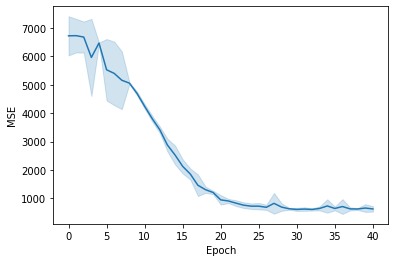

In [45]:
import math
agent = EvalAgent(config=config_td, policy=policy)
agent.training_batch(epochs=1000, batch_size=256)

## Advantage Actor Critic (A2C)
**Implementation of the A2C method**


In [0]:
class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
        
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        # Returns
        cum_discounted_rewards = [next_value]

        for t in range(len(rewards)-1,-1,-1):
          if not dones[t]:
            cum_discounted_rewards+=[rewards[t]+cum_discounted_rewards[-1]*self.gamma]
          else:
            cum_discounted_rewards+=[rewards[t]]
        cum_discounted_rewards=np.array(cum_discounted_rewards[1:])[::-1]
        cum_discounted_rewards=cum_discounted_rewards.ravel()
        # Advantages
        advantages = cum_discounted_rewards - values
        return cum_discounted_rewards,advantages

    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        rewards_test = []

        for epoch in range(epochs):
          
          # Lets collect one batch
          for i in range(batch_size):
            #tensors and numpy array share same memory location
            observations[i] = observation
            state=torch.from_numpy(observation).float()
            action=self.actor_network.select_action(state)
            actions[i] = action.item()

            #values for Actor Network 
            values[i]=self.value_network.forward(state)
            new_state, reward, done, _ = self.env.step(int(action))
            rewards[i]=reward
            dones[i]=done
            state = torch.from_numpy(new_state).float()
            observation=new_state
            if dones[i]:
                observation = self.env.reset()
          # If our epiosde didn't end on the last step we need to compute the value for the last state
          if dones[-1]:
              next_value = 0

          else:
              next_value = self.value_network(torch.tensor(new_state, dtype = torch.float)).item()

            # If our epiosde didn't end on the last step we need to compute the value for the last state
            
          # Update episode_count
          episode_count += sum(dones)

          # Compute returns and advantages
          
          returns,advantages = self._returns_advantages(rewards, dones,values, next_value)
          
          # Learning step !
          
          self.optimize_model(observations, actions, returns,advantages)
          

          # Test it every 50 epochs
          if epoch % 50 == 0 or epoch == epochs - 1:
              rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
              print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

              # Early stopping
              if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                  print('Early stopping !')
                  break
              observation = self.env.reset()
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
        print(f'The trainnig was done over a total of {episode_count} episodes')

    def optimize_model(self, observations, actions, returns, advantages):
        actions = torch.tensor(actions, dtype = int)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)
        #log probability for Actor Gradient Decent
        actions_proba=self.actor_network.forward(observations)
        log_prob=torch.log(actions_proba)
        log_prob=torch.diag(log_prob.T[actions])
        #Here we pass the whole batch to the loss function with mean reduction
        values=self.value_network(observations) 
        #Critic Network Loss
        loss_critic=F.mse_loss(returns,values)
        #Actor Network Loss 
        loss_actor=(-log_prob * advantages).mean()
        # Discard previous gradients
        self.value_network_optimizer.zero_grad() 
        self.actor_network_optimizer.zero_grad() 
        # Compute the gradient 
        loss_critic.backward()
        loss_actor.backward()
        # Do the gradient descent step
        self.value_network_optimizer.step()
        self.actor_network_optimizer.step()
        

    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            observation, reward, done, info = env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

Create configuration for A2C

In [47]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
actor_learning_rate = 0.001
gamma = 0.99
entropy = 1
seed = 1

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
pprint(config_a2c)

Current config_a2c is:
{'actor_network': {'learning_rate': 0.001},
 'entropy': 1,
 'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001}}


Run the learning agent

Epoch 0/1000: Mean rewards: 24.86, Std: 16.4
Epoch 50/1000: Mean rewards: 38.02, Std: 27.48
Epoch 100/1000: Mean rewards: 55.56, Std: 28.22
Epoch 150/1000: Mean rewards: 78.32, Std: 48.86
Epoch 200/1000: Mean rewards: 121.7, Std: 74.73
Epoch 250/1000: Mean rewards: 218.62, Std: 100.44
Epoch 300/1000: Mean rewards: 222.06, Std: 91.65
Epoch 350/1000: Mean rewards: 223.08, Std: 89.25
Epoch 400/1000: Mean rewards: 336.12, Std: 136.32
Epoch 450/1000: Mean rewards: 350.88, Std: 128.04
Epoch 500/1000: Mean rewards: 407.12, Std: 119.78
Epoch 550/1000: Mean rewards: 411.02, Std: 109.8
Epoch 600/1000: Mean rewards: 415.46, Std: 97.9
Epoch 650/1000: Mean rewards: 426.66, Std: 111.29
Epoch 700/1000: Mean rewards: 456.66, Std: 89.69
Epoch 750/1000: Mean rewards: 475.4, Std: 73.47
Epoch 800/1000: Mean rewards: 477.78, Std: 56.63
Epoch 850/1000: Mean rewards: 462.88, Std: 73.34
Epoch 900/1000: Mean rewards: 407.08, Std: 94.05
Epoch 950/1000: Mean rewards: 444.98, Std: 79.77
Epoch 999/1000: Mean rewar

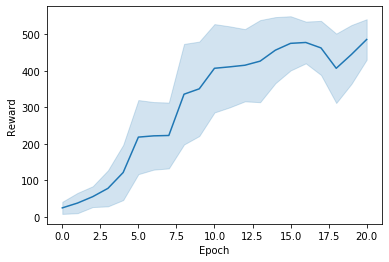

In [48]:
agent = A2CAgent(config_a2c)
rewards = agent.training_batch(1000, 256)

Evaluate the agent over multiple episodes

In [49]:
agent.evaluate()

500.0